In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import numpy as np
from gmm_fairlet_decomposition import VanillaFairletDecomposition, MCFFairletDecomposition
from scipy.spatial import distance
from MWD_utils import *
from sklearn.mixture import GaussianMixture

In [2]:
def draw_ellipse(position, covariance,col, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle,color=col, **kwargs))

In [3]:
import pickle
dataset = 'Data/Simulation'

file = 'Data/Simulation/A.pkl'
pkl_file = open(file, 'rb')
A =pickle.load(pkl_file)
pkl_file.close()

file = 'Data/Simulation/arr.pkl'
pkl_file = open(file, 'rb')
arr =pickle.load(pkl_file)
pkl_file.close()

file = 'Data/Simulation/centers.pkl'
pkl_file = open(file, 'rb')
centers =pickle.load(pkl_file)
pkl_file.close()

file = 'Data/Simulation/fairlets.pkl'
pkl_file = open(file, 'rb')
fairlets =pickle.load(pkl_file)
pkl_file.close()

## Decomposition

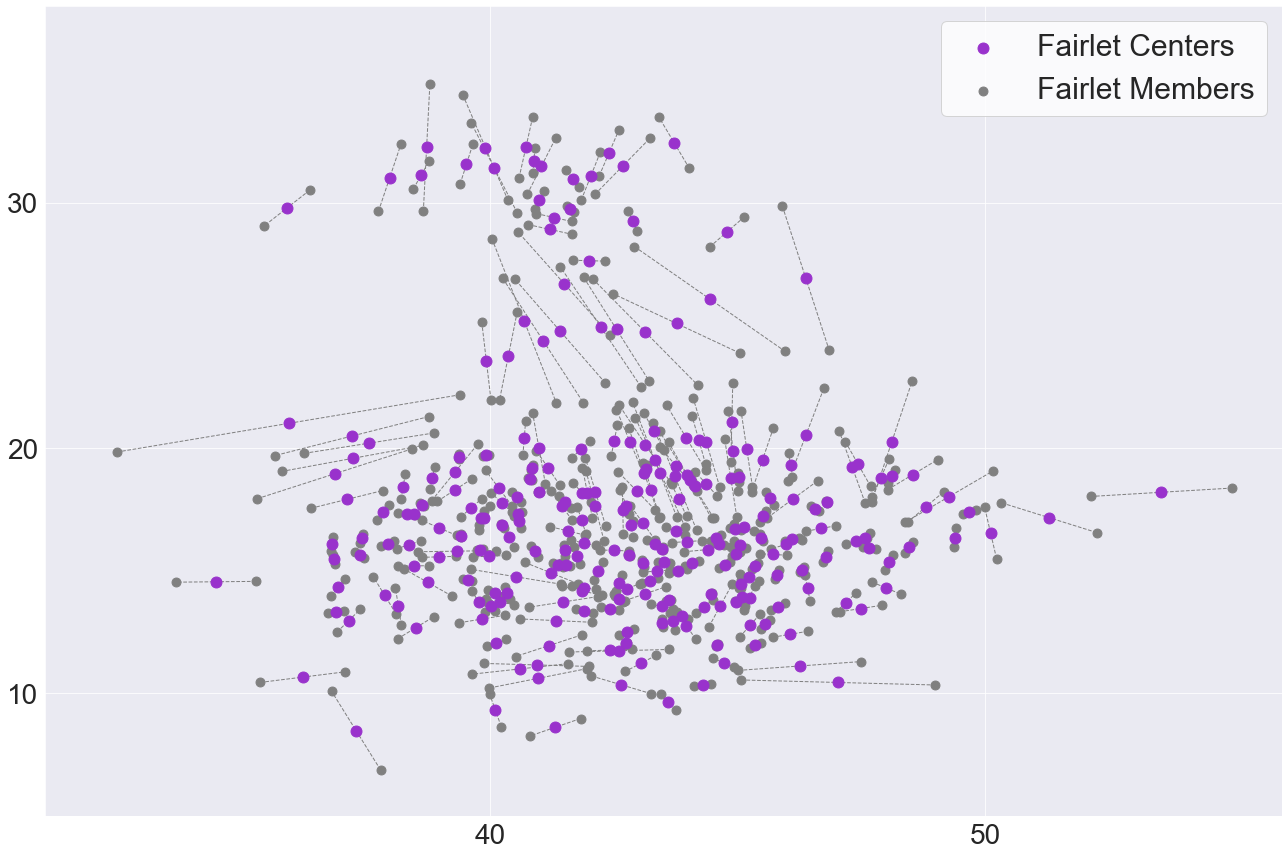

In [4]:
N = len(arr)
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline  
plt.figure(figsize=(18,12))
fontsize=30


B=[]
for i in range(N):
    if A[i]==1:
        B.append('firebrick')
    if A[i]==0:
        B.append('steelblue')
        
for i in range(len(centers)):
    center_index = i 
    arr_index = centers[center_index]
    c = fairlets[center_index]
    
    non_center = list(np.where(np.array(c)!=arr_index)[0])
    
    for j in non_center:
        con = [arr_index,c[j]]
        plt.plot(arr[con,0], arr[con,1], '--',color='grey',alpha=1,linewidth=1,zorder=1) # Connect first two data points
s = 100
plt.scatter(arr[:,0],arr[:,1],c='grey',s=s-20,alpha=1)
plt.scatter(np.mean(arr[fairlets],axis=1)[:,0],np.mean(arr[fairlets],axis=1)[:,1],color='darkorchid',marker='o',s=s+20,zorder=10)
plt.scatter([],[],label='Fairlet Centers',c='darkorchid',s=s+20)
plt.scatter([],[],label='Fairlet Members',c='grey',s=s-20)
plt.legend(fontsize=fontsize,loc='upper right',facecolor='white');
plt.xticks(fontsize=fontsize-2);
plt.yticks(fontsize=fontsize-2);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))
ax = plt.gca()
ax.tick_params(width=6)
plt.axis([31,56,5,38]);
plt.tight_layout()
#plt.savefig('figs/Simulation_Decomp.pdf')

## Data with colors

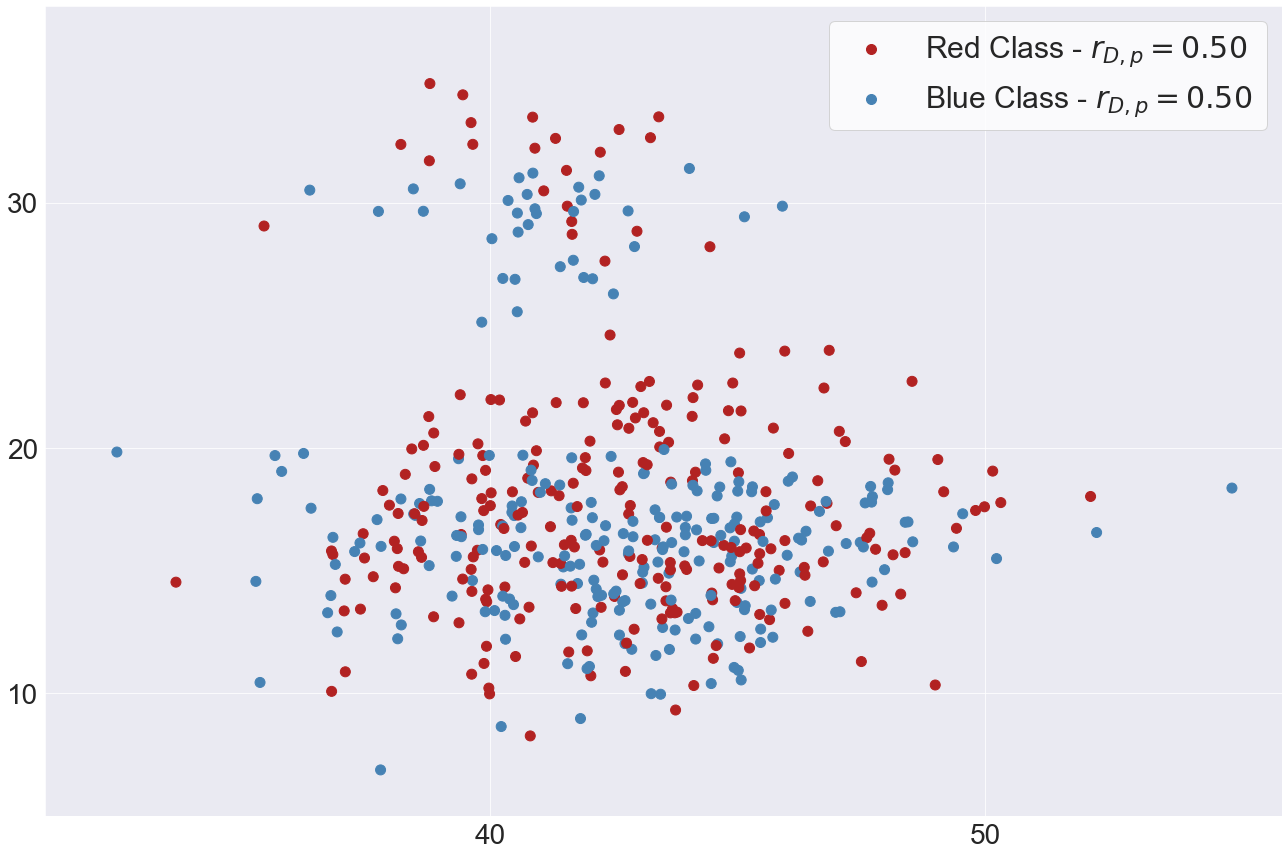

In [5]:
plt.figure(figsize=(18,12))
fontsize=30
B=[]
for i in range(N):
    if A[i]==1:
        B.append('firebrick')
    if A[i]==0:
        B.append('steelblue')
        
s = 100
plt.scatter(arr[:,0],arr[:,1],c=B,alpha=1,s=s)
plt.scatter([],[],label=r'Red Class - $r_{D,p} = 0.50$',c='firebrick',s=s)
plt.scatter([],[],label=r'Blue Class - $r_{D,p} = 0.50$ ',c='steelblue',s=s)
plt.legend(fontsize=fontsize,loc='upper right',facecolor='white');
plt.xticks(fontsize=fontsize-2);
plt.yticks(fontsize=fontsize-2);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))
plt.axis([31,56,5,38]);
ax = plt.gca()
ax.tick_params(width=6)
plt.tight_layout();
#plt.savefig('figs/Simulation_Data.pdf')

## Colorblind GMM

Entropy Ratio	 0.98967 
Balance		 0.80576

r_D in full set 0.5

Weighted fraction in clusters
[0.40287782 0.51226616]


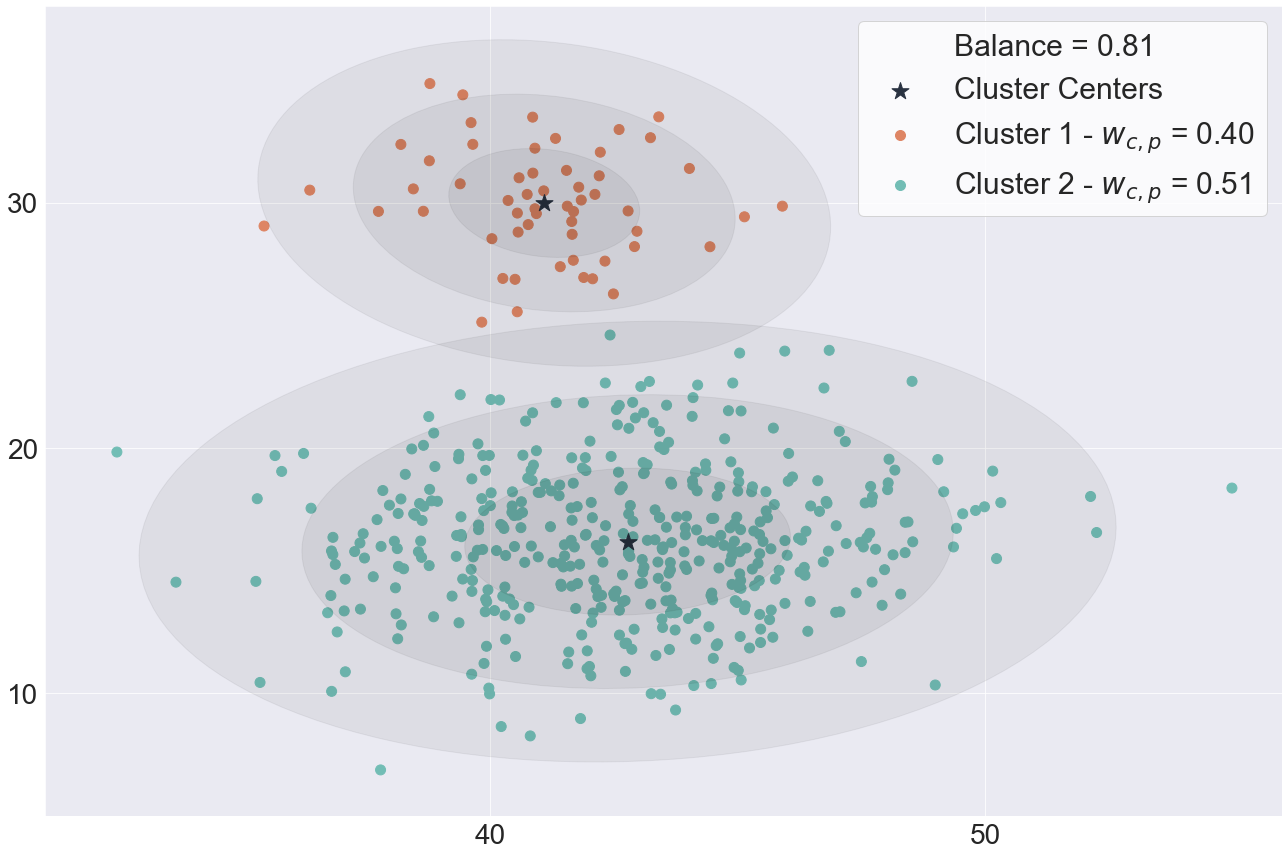

In [6]:
# Colorblind model 
random_state = 0
n_components = 2
gm_full = GaussianMixture(n_components=n_components, random_state=random_state,covariance_type='full',max_iter=100,n_init=3,init_params='k-means++').fit(arr)
gamma_full = gm_full.predict_proba(arr)
w_all = gm_full.weights_
means_all = gm_full.means_
covs_all = gm_full.covariances_

gamma = gamma_full
H1,H_ratio1,balance1,p1 = soft_fairness(gamma,A)
H2,H_ratio2,balance2,p2 = soft_fairness(gamma,1-A)

balance = np.min([balance1,balance2])
H_ratio = np.min([H_ratio1,H_ratio2])

if np.argmin([balance1,balance2]) == 0:
    p = p1
    r_d = sum(A)/len(A)
else:
    p = p2
    r_d = sum(1-A)/len(1-A)

print(f'Entropy Ratio\t {round(H_ratio,5)} \nBalance\t\t {round(balance,5)}')
print(f'\nr_D in full set {r_d}')
print(f'\nWeighted fraction in clusters\n{p}')
N = len(arr)

prob = gamma_full
# Cluster assignment by maximum probability
preds=np.zeros([N])
for i in range(N):
    preds[i] = np.argmax(prob[i])
    
# Plotting assigned clusters
color=[]
for i in range(N):
    if preds[i]==0:
        color.append('#DE8564')
    if preds[i]==1:
        color.append('#72BDB5')
plt.figure(figsize=(18,12))
fontsize=30
s = 100
w_factor = 0.05 /  w_all.max()
for pos, covar, w in zip(means_all, covs_all, w_all):
    draw_ellipse(pos, covar, alpha=w_factor,col='black')
string = 'Balance ='
plt.plot([],[],'',label=f'{string} {"%.2f" % round(balance,2)}',linewidth=0)
plt.scatter(arr[:,0],arr[:,1],c=color,s=s);
plt.scatter(means_all[:,0],means_all[:,1],color='#293241',s=320,marker='*',label='Cluster Centers')
string = r'$w_{c,p}$'
plt.scatter([],[],label=f'Cluster 1 - {string} = {"%.2f" % round(p[0],2)}',c='#DE8564',s=s)
plt.scatter([],[],label=f'Cluster 2 - {string} = {"%.2f" % round(p[1],2)}',c='#72BDB5',s=s)
plt.legend(fontsize=fontsize,loc='upper right',facecolor='white');
plt.xticks(fontsize=fontsize-2);
plt.yticks(fontsize=fontsize-2);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))
plt.tight_layout()
ax = plt.gca()
ax.tick_params(width=6)
plt.axis([31,56,5,38]);
#plt.savefig('figs/Simulation_Unfair.pdf')

## Fair GMM

Entropy Ratio	 1.0 
Balance		 1.0

r_D in full set 0.5

Weighted fraction in clusters
[0.5 0.5]


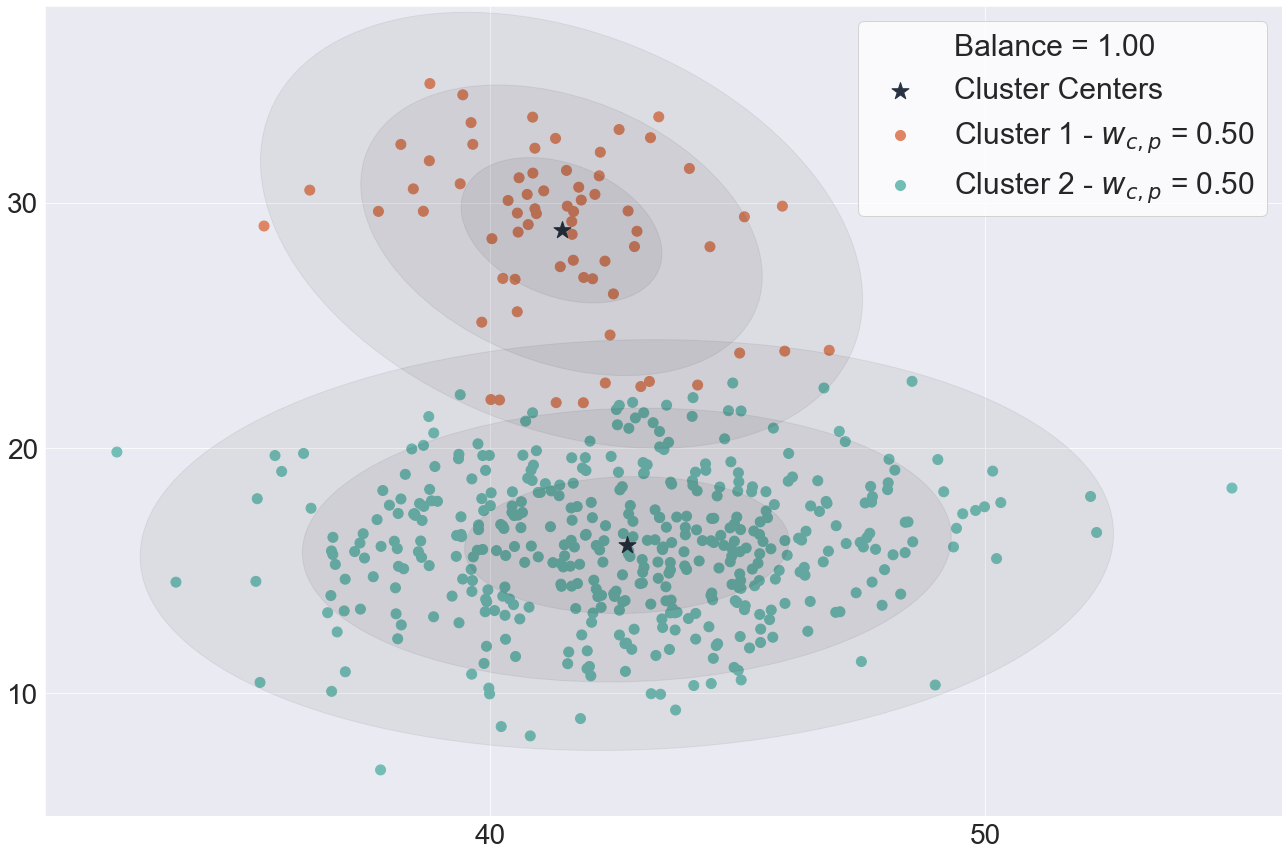

In [7]:
import numpy as np
centers_mean = []
for i in range(len(fairlets)):
    centers_mean.append(np.mean(arr[fairlets[i]],axis=0))
centers_mean = np.array(centers_mean)

#Algorithm 1
fairlet_sizes = [len(fairlets[i]) for i in range(len(centers))] # size of fairlets
Pbar=[]
for i in range(len(centers)):
    for j in range(fairlet_sizes[i]):
        Pbar.append(centers_mean[i])
Pbar = np.asarray(Pbar)

gm_fair = GaussianMixture(n_components=2, random_state=random_state,covariance_type='full',max_iter=100,n_init=3,init_params='k-means++').fit(Pbar)
gamma_fair = gm_fair.predict_proba(centers_mean)
w_all_fair = gm_fair.weights_
means_all_fair = gm_fair.means_
covs_all_fair = gm_fair.covariances_

# Setting correct index for gamma to compute fairness.
center_gamma = gm_fair.predict_proba(centers_mean) # responsibility of centers
gamma=np.zeros([arr.shape[0],2])
for i in range(len(centers)):
            gamma[fairlets[i]] = center_gamma[i]

H1,H_ratio1,balance1,p1 = soft_fairness(gamma,A)
H2,H_ratio2,balance2,p2 = soft_fairness(gamma,1-A)
balance = np.min([balance1,balance2])
H_ratio = np.min([H_ratio1,H_ratio2])

if np.argmin([balance1,balance2]) == 0:
    p = p1
    r_d = sum(A)/len(A)
else:
    p = p2
    r_d = sum(1-A)/len(1-A)
print(f'Entropy Ratio\t {round(H_ratio,5)} \nBalance\t\t {round(balance,5)}')
print(f'\nr_D in full set {r_d}')
print(f'\nWeighted fraction in clusters\n{p}')

# Assignment from fairlet centers
prob = gamma_fair
# Fairlet center assignment by maximum probability
fairlet_preds=np.zeros([len(centers)])
for i in range(len(centers)):
    fairlet_preds[i] = np.argmax(prob[i])

# Assigning fairlet members according to the center assignment
preds =  np.zeros(N)
for i in range(len(centers)):
    preds[fairlets[i]] = fairlet_preds[i]

# Plotting assigned clusters
color=[]
for i in range(N):
    if preds[i]==1:
        color.append('#DE8564')
    if preds[i]==0:
        color.append('#72BDB5')
plt.figure(figsize=(18,12))
fontsize=30
s= 100
w_factor = 0.05 /  w_all_fair.max()
for pos, covar, w in zip(means_all_fair, covs_all_fair, w_all_fair):
    draw_ellipse(pos, covar, alpha=w_factor,col='black')
string = 'Balance ='
plt.plot([],[],'',label=f'{string} {"%.2f" % round(balance,2)}',linewidth=0)
plt.scatter(arr[:,0],arr[:,1],c=color,s=s);
plt.scatter(means_all_fair[:,0],means_all_fair[:,1],color='#293241',s=320,marker='*',label='Cluster Centers')
string = r'$w_{c,p}$'
plt.scatter([],[],label=f'Cluster 1 - {string} = {"%.2f" % round(p[0],2)}',c='#DE8564',s=s)
plt.scatter([],[],label=f'Cluster 2 - {string} = {"%.2f" % round(p[1],2)}',c='#72BDB5',s=s)
plt.legend(fontsize=fontsize,loc='upper right',facecolor='white');
plt.xticks(fontsize=fontsize-2);
plt.yticks(fontsize=fontsize-2);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))
plt.tight_layout()
plt.axis([31,56,5,38]);
ax = plt.gca()
ax.tick_params(width=6)
#plt.savefig('figs/Simulation_Fair.pdf')